In [1]:
import camelot
import pandas
import matplotlib
import datetime
import numpy as np

In [2]:
# parse the time table in our columns to have a working data format as an intermediary 
def parseTimeTableToDF(filename,timetable): 

    # Working dataframe for timetable 
    df = pandas.DataFrame(columns=["weekday","daynumber","start_time","end_time","type","calculated_amount","glz_saldo"])
    for k,row in timetable.iterrows(): 
        # Parse info from table into our working dataframe
        row_object = {
            "source": filename.split("/")[-1], # get the last filename with .pdf ending
            "weeknum": None,
            "weekday": row[0],
            "year" : None,
            "daynumber": row[1],
            "start_time": row[2],
            "end_time" : row[3],
            "type" : row[4],
            "calculated_amount": row[5],#typecast for later calculation
            "glz_saldo": row[6] #typecast for later calculation
        }
        # We are not interested in Weekends for our timetable
        if row_object["weekday"] not in ["Sa","So"]: 
            df_dictionary = pandas.DataFrame([row_object])
            df = pandas.concat([df,df_dictionary],ignore_index=True)
    return df

# Parse all calulated times into integers 
def parseTimeTableAmount(amount): 
    # we only try to convert if we have a string from the dataframe
    if isinstance(amount, str) and amount != "": 
        amount = amount.replace(",",".")
        if '-' in amount: 
            amount = amount.replace("-","")
            return -float(amount)
        else: 
            return float(amount)
    else: 
        return None


def fill_special_days(df: pandas.DataFrame) -> pandas.DataFrame:
    """
    Replaces 'SPECIAL_DAY' in the 'daynumber' column with the previous non-'SPECIAL_DAY' value + 1.
    """
    df = df.copy()  # Avoid modifying the original DataFrame
    prev_value = "01"
    for i,row in df.iterrows():
        if row["daynumber"] == 'SPECIAL_DAY':
            df.at[i,"daynumber"] = int(prev_value) + 1
            prev_value = int(prev_value) + 1 # set the previous value to our calculated stuff 
        else: 
            # Cast daynumber into integer
            df.at[i,"daynumber"] = int(row["daynumber"])
            # Set previous value for next stepp
            prev_value = row["daynumber"] 

    return df

# def fixCalculatedAmountForFZGZ(entry): 
#     if entry != None and entry[0] != None and entry[1] != None:
#         # If we have a FZGZ entry, the time is reversed (only if we have a valid time)
#         if "FZ-" in entry[0]: 
#             entry[1] = -entry[1]
#     return entry

def fixCalculatedAmountForFZGZ(row):
    amount = str(row["calculated_amount"]).replace(",", ".")  # Ensure decimal format
    try:
        value = float(amount) if amount not in ["None", "nan"] else None
        if pandas.notna(value) and "FZ-" in str(row["type"]):
            return -value  # Make negative if "FZ-" is in type
        return value
    except ValueError:
        return None  # Return None for invalid entries

def getCurrentDatesFromFilename(file_datum): 
    # Calculate the current week of the year from the filename 
    file_year = int(file_datum[:4])
    file_month = int(file_datum[4:6])
    file_day = int(file_datum[6:])
    # Calculate iso-calender datum with these infos from the filename
    return file_year,file_month,file_day

# Use global information from the file to get the week_number
def calculateWeekNumFromWeekday(entry):
    source_name = entry[2].strip(".pdf") # second entry is source filename
    date_infos = getCurrentDatesFromFilename(source_name)
    day = int(entry[0])
    entry[1] = datetime.date(date_infos[0], date_infos[1],day).isocalendar().week
    return entry

def convert24hoursToTimeObject(obj): 
    if not None:
        # Converts the format HH:MM to a datetime object
        return datetime.datetime.strptime(obj, r"%H:%M")
    else: 
        return None

def fill_double_entrys(df: pandas.DataFrame) -> pandas.DataFrame:
    """
    If we have a row without a weekday, daynumber it mostly corresponds to the row above it 
    """
    df = df.copy()  # Avoid modifying the original DataFrame
    for i,row in df.iterrows():
        if row["weekday"] == None and row["daynumber"] == None and row["start_time"] != None: # check if both entrys are empty 
            # Check if previous entrys are full 
            if df.loc[i-1]['weekday'] != None and df.loc[i-1]["daynumber"] != None:

                # We then merge the backfill the empty entry with information from the field and fix the time 
                # df.at[i,"weekday"] = df.iloc[i-1]['weekday']
                df.at[i,"weekday"] = df.loc[i-1]['weekday']
                df.at[i,"daynumber"] = df.loc[i-1]['daynumber']
    return df

def parsePDFFromFile(filename):
    # Sane Defaults for PDF Documents 
    timetable_area = ['40,620,400,300']
    # table_areas accepts strings of the form x1,y1,x2,y2 where (x1, y1) -> top-left and (x2, y2) -> bottom-right in PDF coordinate space. 
    timetable_columm_settings = ['50,68,95,122,220,255,292,325,360']

    # Starting table parsing 
    tables = camelot.read_pdf(filename,flavor="stream",split_text=True, columns=timetable_columm_settings,table_regions =timetable_area )
    camelot.plot(tables[0],kind='grid').savefig('filename.png', dpi=300)
    return tables[0].df

def generalDataFrameCleanup(timetable): 
    # Search for index with keyword "Beginn" 
    idx = timetable.index[timetable["start_time"].eq("Beginn")].min()
    timetable = timetable[idx+1:] # Drop all indexes before "Beginn" to cleanup table 

    # Drop all indexes after "Anspru" because this indicates the end of the table 
    idx = timetable.index[timetable["type"].str.contains("Anspru")].min()
    timetable = timetable[:idx-2] # Drop all indexes behind found index

    # replace field that's entirely space (or empty) with NaN
    timetable.replace(r'^\s*$', None, regex=True,inplace=True)

    # Convert all string times to time objects so we can work with time 
    timetable['start_time'] = pandas.to_datetime(timetable['start_time'], format='%H:%M')

    timetable['end_time'] = pandas.to_datetime(timetable['end_time'], format='%H:%M')

    # Fix empty rows that are created because we have two different time types on the same day 
    timetable = fill_double_entrys(timetable)

    # If we do not have a number in field "daynumber, remove the 
    timetable["daynumber"] = timetable["daynumber"].replace(r'^[a-zA-Z].*', 'SPECIAL_DAY', regex=True)
    # All weekdays which are not valid days of the week will be removed 
    timetable["weekday"] = timetable["weekday"].apply(lambda x: "SPECIAL_DAY" if x not in ["","Mo","Di","Mi","Do","Fr","Sa","So"] else x)

    # We fill in the daynumber of the specialdays by using the daynumber in the row before +1 
    timetable = fill_special_days(timetable)

    # Calculate the week number of the year based on the daynum in the table
    timetable[['daynumber','weeknum',"source"]] = timetable[['daynumber','weeknum','source']].apply(calculateWeekNumFromWeekday,axis=1)
    
    # Set the year for all weeks
    date_infos = getCurrentDatesFromFilename(timetable['source'].iloc[0].strip(".pdf"))
    timetable["year"] = date_infos[0]

    # Fill NaN Columns of Type of Work with Büro
    timetable['type'].fillna(inplace=True,value="Buero") 

    # Parse GLZ and calculated numbers into integers
    timetable['calculated_amount'] = timetable['calculated_amount'].apply(parseTimeTableAmount)
    timetable['glz_saldo'] = timetable['glz_saldo'].apply(parseTimeTableAmount)

    # FIx positive/negative direction of integer for FZGZ 
    timetable["calculated_amount"] = timetable.apply(fixCalculatedAmountForFZGZ, axis=1)  # Apply row-wise    

    return timetable

/tmp/ipykernel_1064/321694063.py:85: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  source_name = entry[2].strip(".pdf") # second entry is source filename
/tmp/ipykernel_1064/321694063.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  day = int(entry[0])
/tmp/ipykernel_1064/321694063.py:88: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  entry[1] = datetime.date(date_infos[0], date_infos[1],day).isocalendar().week
/tmp/ipykerne

,weekday,daynumber,start_time,end_time,type,calculated_amount,glz_saldo,source,weeknum,year
0,SPECIAL_DAY,2,NaT,NaT,MA nicht anwesend,3.20,0.00,20240101.pdf,1,2024
1,Di,2,1900-01-01 08:00:00,1900-01-01 16:15:00,Mobiles Arbeiten,7.75,4.55,20240101.pdf,1,2024
2,Mi,3,NaT,NaT,Krankheit ohne Attest,3.20,0.00,20240101.pdf,1,2024
3,Do,4,1900-01-01 08:00:00,1900-01-01 09:48:00,Mobiles Arbeiten,NaN,NaN,20240101.pdf,1,2024
4,Do,4,1900-01-01 16:00:00,1900-01-01 18:00:00,Mobiles Arbeiten,3.80,0.60,20240101.pdf,1,2024
5,Fr,5,1900-01-01 07:45:00,1900-01-01 12:54:00,Buero,5.15,1.95,20240101.pdf,1,2024
6,Mo,8,1900-01-01 08:00:00,1900-01-01 16:45:00,Mobiles Arbeiten,8.25,5.05,20240101.pdf,2,2024
7,Di,9,1900-01-01 07:30:00,1900-01-01 10:00:00,FZ-Ausgl. GLZ/AZV,-2.50,-3.20,20240101.pdf,2,2024
8,Mi,10,1900-01-01 11:00:00,1900-01-01 15:14:00,Mobiles Arbeiten,4.23,1.03,20240101.pdf,2,2024
9,Do,11,1900-01-01 10:30:00,1900-01-01 15:30:00,Mobiles Arbeiten,5.00,1.80,20240101.pdf,2,2024


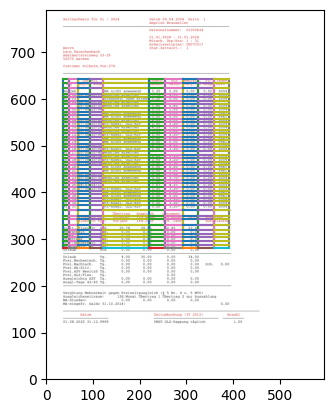

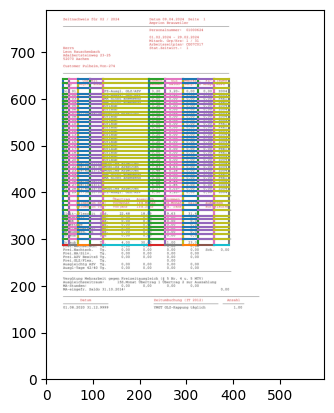

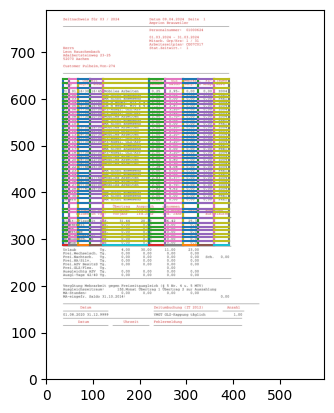

In [3]:
uploaded_files = [
    "/mnt/c/Users/leonr/OneDrive/Amprion/Bescheinigungen/Zeitnachweis/20240101.pdf",
    "/mnt/c/Users/leonr/OneDrive/Amprion/Bescheinigungen/Zeitnachweis/20240201.pdf",
    "/mnt/c/Users/leonr/OneDrive/Amprion/Bescheinigungen/Zeitnachweis/20240301.pdf",
]

yearly_timetable = pandas.DataFrame()

for doc in uploaded_files: 
    camelot_df = parsePDFFromFile(doc)
    timetable = parseTimeTableToDF(doc,camelot_df)
    timetable = generalDataFrameCleanup(timetable)

    yearly_timetable = pandas.concat([yearly_timetable,timetable],ignore_index=True)

yearly_timetable.head(35)

In [4]:
timetable = timetable[3:26]

timetable.head(50)

,weekday,daynumber,start_time,end_time,type,calculated_amount,glz_saldo,source,weeknum,year
5,Mi,6,1900-01-01 07:30:00,1900-01-01 10:00:00,FZ-Ausgl. GLZ/AZV,-2.50,-3.20,20240301.pdf,10,2024
6,Do,7,1900-01-01 07:00:00,1900-01-01 10:00:00,FZ-Ausgl. GLZ/AZV,-2.50,-3.20,20240301.pdf,10,2024
7,Fr,8,1900-01-01 07:30:00,1900-01-01 10:00:00,Mobiles Arbeiten,2.50,-0.70,20240301.pdf,10,2024
8,Mo,11,1900-01-01 15:00:00,1900-01-01 18:00:00,Mobiles Arbeiten,3.00,-0.20,20240301.pdf,11,2024
9,Di,12,1900-01-01 09:00:00,1900-01-01 10:00:00,Mobiles Arbeiten,1.00,-2.20,20240301.pdf,11,2024
10,Mi,13,1900-01-01 09:30:00,1900-01-01 10:30:00,Mobiles Arbeiten,1.00,-2.20,20240301.pdf,11,2024
11,Do,14,1900-01-01 07:30:00,1900-01-01 10:00:00,FZ-Ausgl. GLZ/AZV,-2.50,-3.20,20240301.pdf,11,2024
12,Fr,15,1900-01-01 07:30:00,1900-01-01 10:00:00,FZ-Ausgl. GLZ/AZV,-2.50,-3.20,20240301.pdf,11,2024
13,Mo,18,1900-01-01 07:30:00,1900-01-01 10:00:00,FZ-Ausgl. GLZ/AZV,-2.50,-3.20,20240301.pdf,12,2024
14,Di,19,1900-01-01 08:00:00,1900-01-01 12:00:00,Mobiles Arbeiten,4.00,0.80,20240301.pdf,12,2024


In [5]:
yearly_timetable_without_fzgz = yearly_timetable[yearly_timetable['type'] != ("FZ-Ausgl. GLZ/AZV")]

In [6]:
yearly_timetable.head(35)


,weekday,daynumber,start_time,end_time,type,calculated_amount,glz_saldo,source,weeknum,year
0,SPECIAL_DAY,2,NaT,NaT,MA nicht anwesend,3.20,0.00,20240101.pdf,1,2024
1,Di,2,1900-01-01 08:00:00,1900-01-01 16:15:00,Mobiles Arbeiten,7.75,4.55,20240101.pdf,1,2024
2,Mi,3,NaT,NaT,Krankheit ohne Attest,3.20,0.00,20240101.pdf,1,2024
3,Do,4,1900-01-01 08:00:00,1900-01-01 09:48:00,Mobiles Arbeiten,NaN,NaN,20240101.pdf,1,2024
4,Do,4,1900-01-01 16:00:00,1900-01-01 18:00:00,Mobiles Arbeiten,3.80,0.60,20240101.pdf,1,2024
5,Fr,5,1900-01-01 07:45:00,1900-01-01 12:54:00,Buero,5.15,1.95,20240101.pdf,1,2024
6,Mo,8,1900-01-01 08:00:00,1900-01-01 16:45:00,Mobiles Arbeiten,8.25,5.05,20240101.pdf,2,2024
7,Di,9,1900-01-01 07:30:00,1900-01-01 10:00:00,FZ-Ausgl. GLZ/AZV,-2.50,-3.20,20240101.pdf,2,2024
8,Mi,10,1900-01-01 11:00:00,1900-01-01 15:14:00,Mobiles Arbeiten,4.23,1.03,20240101.pdf,2,2024
9,Do,11,1900-01-01 10:30:00,1900-01-01 15:30:00,Mobiles Arbeiten,5.00,1.80,20240101.pdf,2,2024


In [7]:
yearly_timetable_without_fzgz.head(10)

,weekday,daynumber,start_time,end_time,type,calculated_amount,glz_saldo,source,weeknum,year
0,SPECIAL_DAY,2,NaT,NaT,MA nicht anwesend,3.20,0.00,20240101.pdf,1,2024
1,Di,2,1900-01-01 08:00:00,1900-01-01 16:15:00,Mobiles Arbeiten,7.75,4.55,20240101.pdf,1,2024
2,Mi,3,NaT,NaT,Krankheit ohne Attest,3.20,0.00,20240101.pdf,1,2024
3,Do,4,1900-01-01 08:00:00,1900-01-01 09:48:00,Mobiles Arbeiten,NaN,NaN,20240101.pdf,1,2024
4,Do,4,1900-01-01 16:00:00,1900-01-01 18:00:00,Mobiles Arbeiten,3.80,0.60,20240101.pdf,1,2024
5,Fr,5,1900-01-01 07:45:00,1900-01-01 12:54:00,Buero,5.15,1.95,20240101.pdf,1,2024
6,Mo,8,1900-01-01 08:00:00,1900-01-01 16:45:00,Mobiles Arbeiten,8.25,5.05,20240101.pdf,2,2024
8,Mi,10,1900-01-01 11:00:00,1900-01-01 15:14:00,Mobiles Arbeiten,4.23,1.03,20240101.pdf,2,2024
9,Do,11,1900-01-01 10:30:00,1900-01-01 15:30:00,Mobiles Arbeiten,5.00,1.80,20240101.pdf,2,2024
11,Mo,15,1900-01-01 07:55:00,1900-01-01 16:32:00,Buero,8.12,4.92,20240101.pdf,3,2024


Summarize the amount of work did in each week!

In [8]:
yearly_timetable.groupby("weeknum")[['calculated_amount']].sum()

,calculated_amount
weeknum,
1,23.10
2,12.48
3,8.87
4,15.35
5,-16.00
6,17.80
7,16.00
8,26.46
9,13.65


Total Hours Worked

In [9]:
total_hours_worked = yearly_timetable["calculated_amount"].sum()
netflix_epsiode_in_hours = 0.75 * 10 # 45min * 10 episodes


print(f"With your work time you could have watched a total of {round(total_hours_worked / netflix_epsiode_in_hours,1)} netflix shows with 10 episodes")

With your work time you could have watched a total of 22.1 netflix shows with 10 episodes


Based on your hourly rate, you could have bought x amount of Fallschirmsprünge from your worked hours

In [10]:
hourly_rate_in_eur = 40
cost_of_basejump = 400 # From jochen schweizer 
tax_rate_in_percent = 30 # we assume the goverment takes a lot of our money 


amount_of_basejumps = ((total_hours_worked * hourly_rate_in_eur) * ((100-tax_rate_in_percent)/100)) / cost_of_basejump
print(f"You could have bought {amount_of_basejumps} basejumps after tax with the hours you have worked")

You could have bought 11.622099999999998 basejumps after tax with the hours you have worked


You gave X % percent this month (based on a weekly_work_hours_baseline work week)

In [11]:
weekly_work_hours_baseline = 16
amount_of_weeks_worked = len(yearly_timetable["weeknum"].unique())

percent_given = yearly_timetable["calculated_amount"].sum() / (weekly_work_hours_baseline * amount_of_weeks_worked)

print(f"Based on a {weekly_work_hours_baseline} hour work-week, you have worked {percent_given*100}% of that time in the analysed timespan!")

Based on a 16 hour work-week, you have worked 79.82211538461537% of that time in the analysed timespan!


Overtime Champion: How many extra hours did you give to the office this year? Are you eligible for an overtime hall of fame? 🏆

In [12]:
overtime_worked = yearly_timetable["calculated_amount"].sum() - (weekly_work_hours_baseline * amount_of_weeks_worked) 
if overtime_worked > 0: 
    print(f"Overtime Champion. You gave a total of {overtime_worked} hours to the office")
else: 
    print(f'No overtime for you. You valued your personal life more than work life!')

No overtime for you. You valued your personal life more than work life!


Most active day and least active day

In [13]:
def calculateTimeDeltaForTimes(row): 
    return row["end_time"] - row["start_time"]

def days_hours_minutes(td):
    return td.days, td.seconds//3600, (td.seconds//60)%60


# Create a filtered list of timedeltas without NaT values
timedeltas = filter(lambda x: str(x) != 'NaT', list(yearly_timetable.apply(calculateTimeDeltaForTimes,axis=1)))
timedeltas = list(timedeltas)

print("On you're least active day you have worked",days_hours_minutes(min(timedeltas))[1],"hours and",days_hours_minutes(max(timedeltas))[2],"minutes")
print("On you're most active day you have worked",days_hours_minutes(max(timedeltas))[1],"hours and",days_hours_minutes(max(timedeltas))[2],"minutes")

On you're least active day you have worked 0 hours and 25 minutes
On you're most active day you have worked 9 hours and 25 minutes


Work-Life Balance Score: Did your time tracking scream “workaholic” or “master of balance”? ⚖️

In [14]:
# https://www.destatis.de/EN/Themes/Labour/Labour-Market/Quality-Employment/Dimension3/3_1_WeeklyHoursWorked.html
germany_average_worked_hours_per_week = 16 # are you over 40hours in most weeks? 

# Calculate the hours per week of the data
hours_worked_each_week = yearly_timetable.groupby("weeknum")[['calculated_amount']].sum()
overworked_hours = hours_worked_each_week[hours_worked_each_week > germany_average_worked_hours_per_week].count()

# print(len(list(hours_worked_each_week)))
if overworked_hours["calculated_amount"] > 3: 
    print(f'Workaholic! Out of {len(hours_worked_each_week)} weeks, you did overtime in {overworked_hours["calculated_amount"]} weeks')
else: 
    print(f'Master of balance! Out of {len(hours_worked_each_week)} weeks, you did overtime in {overworked_hours["calculated_amount"]} weeks')

Workaholic! Out of 13 weeks, you did overtime in 5 weeks


Most Productive Week: If your weeks were competing in the Work Olympics, which one would take home the gold medal? 🥇

In [15]:
hours_worked_each_week
index_of_week_with_max_hours = hours_worked_each_week['calculated_amount'].idxmax()
week = hours_worked_each_week.iloc[index_of_week_with_max_hours]

print(f'Most Productive Week: If your weeks were competing in the Work Olympics, week {index_of_week_with_max_hours} would have won with {week['calculated_amount']} hours🥇')

Most Productive Week: If your weeks were competing in the Work Olympics, week 8 would have won with 13.649999999999999 hours🥇


"Peak Rage Quit Hour" 😡 At what time were you most likely to log off in frustration? Should we start a support group for the 3:57 PM Ragers?

In [16]:
yearly_timetable['end_time'].describe()

df_leaving_times = pandas.DataFrame()
df_leaving_times['hour'] = yearly_timetable_without_fzgz['end_time'].dt.hour
df_leaving_times['minute'] = yearly_timetable_without_fzgz['end_time'].dt.minute

# Group by hour and minute
common_times = df_leaving_times.groupby(['hour', 'minute']).size().reset_index(name='count')

# Find the most common log-off time
most_common = common_times.sort_values(by='count', ascending=False)  
logoff_time = f'{round(most_common.iloc[0]['hour'])}:{round(most_common.iloc[0]['minute'])}'
print(f'"Peak Rage Quit Hour" 😡 At {logoff_time} you were most likely to log off in frustration? Should we start a support group for the {logoff_time} PM Ragers?')

"Peak Rage Quit Hour" 😡 At 10:0 you were most likely to log off in frustration? Should we start a support group for the 10:0 PM Ragers?


Early bird or long sleeper? When did you usally start work? 

In [17]:
df_start_time = pandas.DataFrame()
df_start_time['hour'] = yearly_timetable_without_fzgz['start_time'].dt.hour
df_start_time['minute'] = yearly_timetable_without_fzgz['start_time'].dt.minute

# Group by hour and minute
common_times_staring = df_start_time.groupby(['hour', 'minute']).size().reset_index(name='count')
most_common_start = common_times_staring.sort_values(by='count', ascending=False)  
logon_time = f'{round(most_common_start.iloc[0]['hour'])}:{round(most_common_start.iloc[0]['minute'])}'

if most_common_start.iloc[0]['hour'] <= 9: 
    print(f'Early bird? You usally started working at {logon_time}')
else: 
    print(f'Late riser? You usally started working at {logon_time}')

Early bird? You usally started working at 8:0


"Your Work Theme Song" 🎶
Based on your productivity patterns, should your anthem be:

In [18]:
if overworked_hours["calculated_amount"] > 5: 
    theme_song = "Takin' Care of Business - Bachman-Turner Overdrive"
    print(f'"Your Work Theme Song" Based on your overtime patterns it should be "{theme_song}"')
elif overworked_hours["calculated_amount"] > 3: 
    theme_song = "Work - Rihanna ft. Drake"
    print(f'"Your Work Theme Song" Based on your overtime patterns it should be "{theme_song}"')
else: 
    theme_song = "9 to 5 - Dolly Parton"
    print(f'"Your Work Theme Song" Based on your overtime patterns it should be "{theme_song}"')

"Your Work Theme Song" Based on your overtime patterns it should be "Work - Rihanna ft. Drake"


🏝️ Vacation MVP:
You took 4 days off in one go—are you a master of strategic leave planning, or did you just really need a break?

In [19]:
df_vaction_calc = pandas.DataFrame()
df_vaction_calc["is_urlaub"] = yearly_timetable["type"] == "Urlaub"

# Identify consecutive sequences using cumsum on changes
df_vaction_calc["group"] = (df_vaction_calc["is_urlaub"] != df_vaction_calc["is_urlaub"].shift()).cumsum()

urlaub_groups = (
    df_vaction_calc[df_vaction_calc["is_urlaub"]]
    .groupby("group", group_keys=False)["is_urlaub"]
    .apply(lambda x: (x.index[0], x.index[-1]))
)

# Find the longest sequence
longest_sequence = max(urlaub_groups, key=lambda x: x[1] - x[0], default=None)
if longest_sequence != None: 
    sequence_length = longest_sequence[1] - longest_sequence[0] + 1
    print(f"🏝️ Vacation MVP: You took {sequence_length} days off in one go—are you a master of strategic leave planning, or did you just really need a break?")
else: 
    print(f"🏝️ No vacation days logged in the data. You sure you don't wanna go to the beach? ")


🏝️ Vacation MVP: You took 9 days off in one go—are you a master of strategic leave planning, or did you just really need a break?


📆 The "Longest Weekend Ever" Award:
You took off Tuesday, Wednesday, and Friday—did Thursday even count as a workday, or was it just a formality?

In [20]:
# Define holiday types
holiday_types = ["Urlaub", "FZ-Ausgl. GLZ/AZV"]

# Filter for Friday and Monday rows where the user was on holiday.
fridays = yearly_timetable[(yearly_timetable["weekday"] == "Fr") & (yearly_timetable["type"].isin(holiday_types))].copy()
mondays = yearly_timetable[(yearly_timetable["weekday"] == "Mo") & (yearly_timetable["type"].isin(holiday_types))].copy()

# For Monday rows, calculate the previous week number.
mondays["prev_weeknum"] = mondays["weeknum"] - 1

# Merge: match a Friday with a Monday where Monday's previous week equals Friday's weeknum and the year is the same.
long_weekends = fridays.merge(mondays, left_on=["weeknum", "year"], right_on=["prev_weeknum", "year"], suffixes=("_fr", "_mo"))

if not long_weekends.empty:
    print(f"The master of scheduling! You took {len(long_weekends)} long weekends")
else:
    print("What a shame. You took no long weekends.")

The master of scheduling! You took 5 long weekends


📊 "GLZ_Saldo: 0.00"
You maintained a perfect balance—were with overtime in the calender week x you a time management wizard, or did you just make sure HR wouldn't notice?

In [21]:
hours_week_upper_lower_tolerance = 1

hours_week_glz_balance = (hours_worked_each_week < weekly_work_hours_baseline+hours_week_upper_lower_tolerance) & (hours_worked_each_week > weekly_work_hours_baseline-hours_week_upper_lower_tolerance)

# Check if there is any True in the column
if hours_week_glz_balance['calculated_amount'].any():
    result = hours_week_glz_balance.loc[hours_week_glz_balance['calculated_amount']].iloc[0]
else:
    result = hours_week_glz_balance.iloc[0]


if result['calculated_amount'] == True: 
    print(f"📊GLZ_Saldo: 0.00. You maintained a near perfect balance—were with overtime in calender week {result.name}. You are a time management wizard, or did you just make sure HR wouldn't notice")
else: 
    print(f"📊GLZ_Saldo: 0.00. You never achieved a week without overtime? Try to spend some time with your family")



📊GLZ_Saldo: 0.00. You maintained a near perfect balance—were with overtime in calender week 4. You are a time management wizard, or did you just make sure HR wouldn't notice


This was your favorite time of time entry (e.g type filtering)

In [22]:
favorite_type = yearly_timetable.groupby(['type']).size().reset_index(name='count').max()
print(f'Your favorite type of work, {favorite_type["type"]} with {favorite_type["count"]} entrys')


Your favorite type of work, Urlaub with 27 entrys


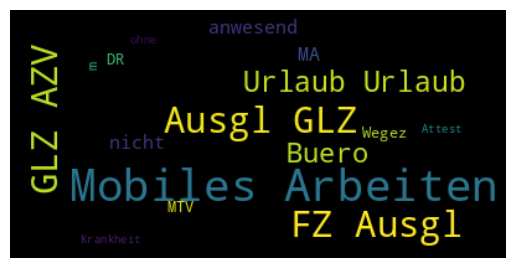

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create some sample text



In [43]:
yearly_timetable['type'].value_counts()

type
Mobiles Arbeiten         27
FZ-Ausgl. GLZ/AZV        16
Urlaub                   11
Buero                     8
MA nicht anwesend         3
DR m Wegez. MTV § 4 A     2
Krankheit ohne Attest     1
Name: count, dtype: int64